In [1]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download NLTK data if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Load a pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.to(device)  # Move the model to the GPU if available

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [4]:
# Check if GPU is available, and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Wrap the model in the DataParallel wrapper
model = torch.nn.DataParallel(model)

In [6]:
# Function to remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text_without_punct = text.translate(translator)
    return text_without_punct

# Function to lowercase text
def lowercase_text(text):
    return text.lower()

# Function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Function to preprocess text
def preprocess_text(text):
    # Add more preprocessing steps as needed
    text = remove_punctuation(text)
    text = lowercase_text(text)
    text = remove_stop_words(text)
    return text

# Function to get BERT embeddings
def get_bert_embeddings(text):
    # This function should be defined with the appropriate model and tokenizer setup.
    # Make sure to define and load the model and tokenizer before calling this function.
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.cpu().numpy()


In [37]:
# Read the CSV file
data = pd.read_csv('FinalDataF.csv', encoding='latin-1')


In [38]:
# Merge the 'Title' and 'Abstract' columns into a single column called 'Text'
data['Text'] = data['Title'].fillna('') + ' ' + data['Abstract'].fillna('')


In [39]:

def preprocess_and_get_embeddings(row):
    text = row.get('Text', '')  # Use get() to handle missing values
    embeddings = get_bert_embeddings(text)
    return embeddings

# Assuming 'data' is your DataFrame
data['Text'] = data['Text'].apply(preprocess_text)

# Process and obtain embeddings for each row
embeddings = data.apply(preprocess_and_get_embeddings, axis=1)
embeddings = np.vstack(embeddings.to_numpy())  # Convert to a NumPy array



In [40]:
# Concatenate the embeddings with the original DataFrame
data = pd.concat([data, pd.DataFrame(embeddings)], axis=1)

In [41]:
# Check the shape of text_embeddings
#text_embeddings = embeddings  # Assign the embeddings to text_embeddings
print(embeddings.shape)  # Should be (number_of_samples, embedding_dimension)

(326, 768)


In [42]:
# Define a function to display BERT embeddings and preprocessed text
def display_bert_embedding_and_preprocessing(data, row_idx):
    # Get BERT embeddings for the specified row
    embedding = data.iloc[row_idx, -768:]  # Assuming the embeddings have 768 dimensions
    preprocessed_text = data.iloc[row_idx]['Text']

    # Display BERT embeddings
    print("BERT Embeddings:")
    print(embedding)
    
    # Display preprocessed text
    print("\nPreprocessed Text:")
    print(preprocessed_text)

# Choose a row to display (change row_idx to the desired row)
row_idx = 200 # Change this to the index of the row you want to display
display_bert_embedding_and_preprocessing(data, row_idx)


BERT Embeddings:
0     -0.151355
1      0.269705
2      0.323128
3      0.105963
4      0.189438
         ...   
763   -0.053525
764   -0.463403
765   -0.289731
766    0.128621
767    0.513295
Name: 200, Length: 768, dtype: object

Preprocessed Text:
medical supplies inventory distribution system pnp hospital pharmacy pnp regional xiii health service hospital uses traditional way inventory medical supplies equipment performing daily transactions paper pen used recording supplies thus results poor inventory management product availability monitoring deemed necessary response pnp working environment medical supplies inventory system pnp hospital designed help pnp hospital improve staffs work efficiency computerizing parts business process automation inventory monitoring medicines products done properly cope high demand pnp keywords information system inventory inventory system laravel postgresql


In [41]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fastcluster import linkage  # Import linkage from fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from fastcluster import linkage  # Import linkage from fastcluster

In [56]:
# Tokenize the text in your dataset
stop_words = set(stopwords.words('english'))

data['Tokens'] = data['Text'].apply(lambda x: [token for token in tokenizer.tokenize(x) if token not in stop_words])

# Create a list of words based on your tokens
word_list = [word for tokens in data['Tokens'] for word in tokens]

# Perform hierarchical clustering using DIANA
linkage_matrix = linkage(embeddings, method='ward', metric='euclidean')


# Define a function to perform cluster analysis
def perform_cluster_analysis(data, linkage_matrix, min_clusters, max_clusters, word_list):
    results = []

    for num_clusters in range(min_clusters, max_clusters + 1):
        # Perform hierarchical clustering and assign clusters
        cluster_assignments = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_assignments)

        # Calculate cohesion and separation scores
        cluster_centers = []
        for cluster_id in range(1, num_clusters + 1):
            cluster_indices = np.where(cluster_assignments == cluster_id)[0]
            cluster_words = [word_list[i] for i in cluster_indices]
            cluster_centers.append(cluster_words)

        result = {
            'Num_Clusters': num_clusters,
            'Silhouette_Score': silhouette_avg,
            'Cluster_Assignments': cluster_assignments,
            'Cluster_Centers': cluster_centers
        }

        results.append(result)

    return results

# Specify the minimum and maximum number of clusters to consider
min_clusters = 2
max_clusters = 10

# Create a list to store the silhouette scores
silhouette_scores = []

# Perform cluster analysis for the specified range of clusters
results = perform_cluster_analysis(embeddings, linkage_matrix, min_clusters, max_clusters, word_list)

# Print the results for each cluster along with words
for result in results:
    print("Number of Clusters:", result['Num_Clusters'])
    
    # Calculate the silhouette score and store it
    silhouette_avg = result['Silhouette_Score']
    silhouette_scores.append(silhouette_avg)

    for cluster_id, cluster_words in enumerate(result['Cluster_Centers']):
        print(f"Cluster {cluster_id + 1} Words: {', '.join(cluster_words)}")

    print("\n")

# Calculate the average silhouette score
average_silhouette_score = sum(silhouette_scores) / len(silhouette_scores)

# Print the average silhouette score
print("Average Silhouette Score:", average_silhouette_score)

# Choose the optimal number of clusters based on desired scores
optimal_result = max(results, key=lambda x: x['Silhouette_Score'])

# Initialize variables for re-clustering
previous_optimal_num_clusters = optimal_result['Num_Clusters']
optimal_num_clusters = previous_optimal_num_clusters

while True:
    # Re-cluster with the current optimal number of clusters
    optimal_cluster_assignments = fcluster(linkage_matrix, optimal_num_clusters, criterion='maxclust')

    # Check if there's a better result (higher silhouette score)
    silhouette_avg = silhouette_score(embeddings, optimal_cluster_assignments)

    if silhouette_avg > optimal_result['Silhouette_Score']:
        # Update the optimal result and number of clusters
        optimal_result = {
            'Num_Clusters': optimal_num_clusters,
            'Silhouette_Score': silhouette_avg,
            'Cluster_Assignments': optimal_cluster_assignments
        }
        previous_optimal_num_clusters = optimal_num_clusters
        optimal_num_clusters += 1
    else:
        # If no better result, break the loop
        break

# Add cluster assignments to the DataFrame
data['Cluster'] = optimal_cluster_assignments

# Print the optimal cluster analysis results
print("Optimal Number of Clusters:", optimal_num_clusters)
print("Optimal Silhouette Score:", optimal_result['Silhouette_Score'])


Number of Clusters: 2
Cluster 1 Words: case, case, understand, students, ##al, license, license, transaction, used, consist, data, analysis, total, analysis, presented, graphs, conducted, researchers, needs, key, ##words, renewal, professional, professional, case, study, poultry, production, business, egg, production, business, financial, aspects, include, technical, management, context, diagram, life, methodology, data, total, analysis, business, decision, system, demands, growing, market, fire, alarm, system, wireless, network, alarm, network, system, data, transmit, message, server, l, ##7, used, detected, ##tro, data, ##ce, transmitted, server, base, station, placed, used, gs, ##pr, shield, ##mg, ##pr, personnel, charge, building, would, receive, text, using, gs, ##m, ras, ##p, pi, b, arm, collect, micro, interpreted, pi, displayed, output, using, lcd, monitor, node, key, uhf, data, trans, ##p, pi, knowledge, ##d
Cluster 2 Words: study, drivers, license, processes, land, transporta

In [83]:
# Specify the target threshold values for silhouette score, separation, and cohesion
desired_silhouette_score = 0.6
desired_separation_score = 0.2
desired_cohesion_score = 0.1

while True:
    # Re-cluster with the current optimal number of clusters
    optimal_cluster_assignments = fcluster(linkage_matrix, optimal_num_clusters, criterion='maxclust')

    # Calculate silhouette score
    silhouette_avg = silhouette_score(text_embeddings, optimal_cluster_assignments)

    # Calculate cohesion and separation scores
    cohesion_score = calculate_cohesion(optimal_cluster_assignments, text_embeddings)
    separation_score = calculate_separation(optimal_cluster_assignments, text_embeddings)

    # Check if the desired threshold values are met
    if (silhouette_avg >= desired_silhouette_score) and (separation_score <= desired_separation_score) and (cohesion_score <= desired_cohesion_score):
        # Break the loop when the thresholds are met
        break

    # Update the optimal result and number of clusters
    optimal_result = {
        'Num_Clusters': optimal_num_clusters,
        'Silhouette_Score': silhouette_avg,
        'Cohesion_Score': cohesion_score,
        'Separation_Score': separation_score,
        'Cluster_Assignments': optimal_cluster_assignments
    }
    previous_optimal_num_clusters = optimal_num_clusters
    optimal_num_clusters += 1

# Add cluster assignments to the DataFrame
data['Cluster'] = optimal_cluster_assignments

# Print the optimal cluster analysis results
print("Optimal Number of Clusters:", optimal_num_clusters)
print("Optimal Silhouette Score:", optimal_result['Silhouette_Score'])
print("Optimal Cohesion Score:", optimal_result['Cohesion_Score'])
print("Optimal Separation Score:", optimal_result['Separation_Score'])

KeyboardInterrupt: 

In [45]:
from scipy.spatial.distance import pdist

# Define a function to calculate cohesion
def calculate_cohesion(cluster_assignments, data):
    num_clusters = max(cluster_assignments)

    if num_clusters < 2:
        return 0.0

    cohesion_scores = []

    for cluster_id in range(1, num_clusters + 1):
        cluster_indices = np.where(cluster_assignments == cluster_id)[0]
        if len(cluster_indices) < 2:
            continue

        cluster_data = data[cluster_indices]
        pairwise_distances = pdist(cluster_data, metric='euclidean')
        cohesion = np.mean(pairwise_distances)
        cohesion_scores.append(cohesion)

    return np.mean(cohesion_scores)

# Define a function to calculate separation
def calculate_separation(cluster_assignments, data):
    num_clusters = max(cluster_assignments)

    if num_clusters < 2:
        return np.inf

    separation_scores = []

    for cluster_id1 in range(1, num_clusters + 1):
        for cluster_id2 in range(1, num_clusters + 1):
            if cluster_id1 != cluster_id2:
                cluster_indices1 = np.where(cluster_assignments == cluster_id1)[0]
                cluster_indices2 = np.where(cluster_assignments == cluster_id2)[0]

                separation = np.min(np.linalg.norm(data[cluster_indices1][:, np.newaxis] - data[cluster_indices2], axis=2))
                separation_scores.append(separation)

    return np.mean(separation_scores)

# Example usage:

# Assuming you have obtained cluster_assignments from your clustering process
cluster_assignments = optimal_cluster_assignments  # Replace with your actual cluster assignments

# Calculate cohesion and separation
cohesion_score = calculate_cohesion(cluster_assignments, embeddings)
separation_score = calculate_separation(cluster_assignments, embeddings)

# Print the cohesion and separation scores
print("Cohesion Score:", cohesion_score)
print("Separation Score:", separation_score)


Cohesion Score: 6.408606984108948
Separation Score: 3.8370597


In [46]:
# ... (Previous code remains the same)

# Choose the optimal number of clusters based on desired scores
optimal_result = max(results, key=lambda x: x['Silhouette_Score'])

# Re-cluster with the optimal number of clusters
optimal_num_clusters = optimal_result['Num_Clusters']
optimal_cluster_assignments = optimal_result['Cluster_Assignments']

# Add cluster assignments to the DataFrame
data['Cluster'] = optimal_cluster_assignments

# Print the optimal cluster analysis results
print("Optimal Number of Clusters:", optimal_num_clusters)
print("Optimal Silhouette Score:", optimal_result['Silhouette_Score'])

# Show every row's cluster assignment
for index, cluster_assignment in enumerate(optimal_cluster_assignments):
    print(f"Row {index + 1} is assigned to Cluster {cluster_assignment}")

# ... (Continue with further analysis or visualization as needed)


Optimal Number of Clusters: 2
Optimal Silhouette Score: 0.053042173
Row 1 is assigned to Cluster 1
Row 2 is assigned to Cluster 2
Row 3 is assigned to Cluster 2
Row 4 is assigned to Cluster 2
Row 5 is assigned to Cluster 2
Row 6 is assigned to Cluster 2
Row 7 is assigned to Cluster 2
Row 8 is assigned to Cluster 2
Row 9 is assigned to Cluster 1
Row 10 is assigned to Cluster 2
Row 11 is assigned to Cluster 2
Row 12 is assigned to Cluster 2
Row 13 is assigned to Cluster 2
Row 14 is assigned to Cluster 2
Row 15 is assigned to Cluster 1
Row 16 is assigned to Cluster 2
Row 17 is assigned to Cluster 2
Row 18 is assigned to Cluster 2
Row 19 is assigned to Cluster 2
Row 20 is assigned to Cluster 1
Row 21 is assigned to Cluster 2
Row 22 is assigned to Cluster 2
Row 23 is assigned to Cluster 2
Row 24 is assigned to Cluster 2
Row 25 is assigned to Cluster 2
Row 26 is assigned to Cluster 1
Row 27 is assigned to Cluster 2
Row 28 is assigned to Cluster 1
Row 29 is assigned to Cluster 2
Row 30 is ass

Optimal Number of Clusters: 2
Optimal Silhouette Score: 0.053042173


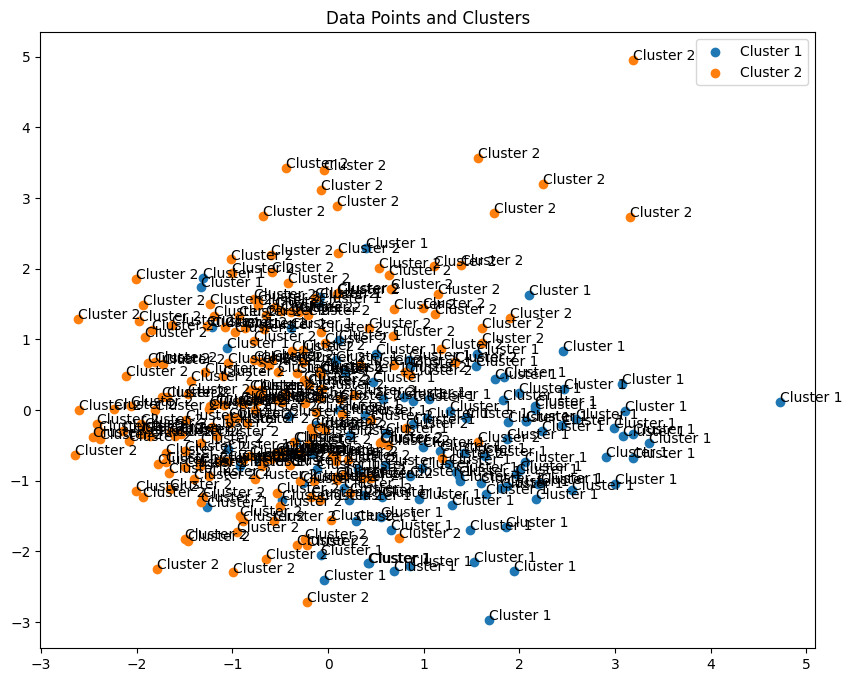

Row 1 is assigned to Cluster 1
Row 2 is assigned to Cluster 2
Row 3 is assigned to Cluster 2
Row 4 is assigned to Cluster 2
Row 5 is assigned to Cluster 2
Row 6 is assigned to Cluster 2
Row 7 is assigned to Cluster 2
Row 8 is assigned to Cluster 2
Row 9 is assigned to Cluster 1
Row 10 is assigned to Cluster 2
Row 11 is assigned to Cluster 2
Row 12 is assigned to Cluster 2
Row 13 is assigned to Cluster 2
Row 14 is assigned to Cluster 2
Row 15 is assigned to Cluster 1
Row 16 is assigned to Cluster 2
Row 17 is assigned to Cluster 2
Row 18 is assigned to Cluster 2
Row 19 is assigned to Cluster 2
Row 20 is assigned to Cluster 1
Row 21 is assigned to Cluster 2
Row 22 is assigned to Cluster 2
Row 23 is assigned to Cluster 2
Row 24 is assigned to Cluster 2
Row 25 is assigned to Cluster 2
Row 26 is assigned to Cluster 1
Row 27 is assigned to Cluster 2
Row 28 is assigned to Cluster 1
Row 29 is assigned to Cluster 2
Row 30 is assigned to Cluster 1
Row 31 is assigned to Cluster 1
Row 32 is assigne

In [47]:
# Re-cluster with the optimal number of clusters
optimal_num_clusters = optimal_result['Num_Clusters']
optimal_cluster_assignments = optimal_result['Cluster_Assignments']

# Add cluster assignments to the DataFrame
data['Cluster'] = optimal_cluster_assignments

# Print the optimal cluster analysis results
print("Optimal Number of Clusters:", optimal_result['Num_Clusters'])
print("Optimal Silhouette Score:", optimal_result['Silhouette_Score'])

# Create a scatter plot to visualize the data points and their clusters
pca = PCA(n_components=2)  # Assuming 2D visualization
data_2d = pca.fit_transform(embeddings)
plt.figure(figsize=(10, 8))

for cluster_id in range(1, optimal_num_clusters + 1):
    cluster_points = data_2d[optimal_cluster_assignments == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')

# Label data points with cluster assignments
for i, label in enumerate(optimal_cluster_assignments):
    plt.annotate(f'Cluster {label}', (data_2d[i, 0], data_2d[i, 1]))

plt.title('Data Points and Clusters')
plt.legend()
plt.show()

# Show every row's cluster assignment
for index, cluster_assignment in enumerate(optimal_cluster_assignments):
    print(f"Row {index + 1} is assigned to Cluster {cluster_assignment}")


In [48]:
# Define a function to preprocess the thesis titles and abstracts and get BERT embeddings
def preprocess_and_get_embeddings(row):
    title = row['Title']
    abstract = row['Abstract']

    # Check for NaN values and return them unchanged
    if pd.isna(title):
        title = ""
    if pd.isna(abstract):
        abstract = ""

    title = remove_punctuation(title)
    title = lowercase_text(title)
    title = remove_stop_words(title)
    title_embeddings = get_bert_embeddings(title)

    abstract = remove_punctuation(abstract)
    abstract = lowercase_text(abstract)
    abstract = remove_stop_words(abstract)
    abstract_embeddings = get_bert_embeddings(abstract)

    return pd.Series({'Title_Embeddings': title_embeddings, 'Abstract_Embeddings': abstract_embeddings})

data.head()

,Title,Abstract,Text,0,1,2,3,4,5,6,...,760,761,762,763,764,765,766,767,Tokens,Cluster
0,A CASE STUDY OF DRIVER'S LICENSE PROCESSES ON ...,A Case Study on Driver's License Processes was...,case study drivers license processes land tran...,-0.269631,0.465857,0.173330,0.085852,0.022887,-0.084005,0.206409,...,-0.109669,0.033354,-0.062445,-0.323334,-0.162837,-0.565800,0.206302,0.199941,"[case, study, drivers, license, processes, lan...",1
1,A CASE STUDY ON POULTRY EGG PRODUCTION BUSINESS,A Case Study on Poultry Egg Production Busines...,case study poultry egg production business cas...,-0.194000,0.145201,0.281167,0.072302,0.274816,0.040862,-0.143095,...,0.002148,-0.053650,0.082827,-0.112260,-0.212029,-0.502998,0.116693,0.117359,"[case, study, poultry, egg, production, busine...",2
2,DESIGN AND DEVELOPMENT OF A FIRE DETECTION AND...,A fire detection and alarm system prototype ba...,design development fire detection alarm system...,-0.366108,0.378146,0.274992,-0.112873,-0.196326,-0.167980,0.097924,...,-0.278952,0.129067,-0.070039,0.033577,-0.025653,-0.613515,0.039527,0.052021,"[design, development, fire, detection, alarm, ...",2
3,"A KNOWLEDGE-BASED SYSTEM N MATCHING TREE, PLAN...","A Knowledge-Based System on Matching of Tree, ...",knowledgebased system n matching tree plant le...,-0.216955,0.321674,0.349871,0.125746,0.147922,-0.046913,0.180015,...,-0.159301,0.052404,0.118972,-0.091455,-0.238157,-0.463038,0.196384,0.328293,"[knowledge, ##base, ##d, system, n, matching, ...",2
4,DESIGN AND DEVELOPMENT OF MEMORANDUM PRIORITIZ...,A memorandum is a means of inter-office corres...,design development memorandum prioritization s...,-0.706261,0.240637,0.046829,0.153465,-0.339577,-0.202548,0.038407,...,-0.178027,-0.096113,0.330406,0.360465,-0.211839,-0.480988,-0.084890,0.427082,"[design, development, memorandum, prior, ##iti...",2
